# ECE 57000 Assignment 4 Exercise

Your Name: David Farache

## Exercise 0: Train your model on GPU (0 points)

For some tasks in this assignment, it can take a long time if you run it on CPU. For example, based on our test on Exercise 3 Task 4, it will take roughly 2 hours to train the full model for 1 epoch on CPU. Hence, we highly recommend you try to train your model on GPU.

To do so, first you need to enable GPU on Colab (this will restart the runtime). Click `Runtime`-> `Change runtime type` and select the `Hardware accelerator` there.  You can then run the following code to see if the GPU is correctly initialized and available.



In [1]:
import torch
print(f'Can I can use GPU now? -- {torch.cuda.is_available()}')

Can I can use GPU now? -- True


### You must manually move your model and data to the GPU (and sometimes back to the cpu)
After setting the GPU up on colab, then you should put your **model** and **data** to GPU. We give a simple example below. You can use `to` function for this task. See [torch.Tensor.to](https://pytorch.org/docs/stable/generated/torch.Tensor.to.html) to move a tensor to the GPU (probably your mini-batch of data in each iteration) or [torch.nn.Module.to](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.to) to move your NN model to GPU (assuming you create subclass [torch.nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html)). Note that `to()` of tensor returns a NEW tensor while `to` of a NN model will apply this in-place. To be safe, the best semantics are `obj = obj.to(device)`. For printing, you will need to move a tensor back to the CPU via the `cpu()` function.

Once the model and input data are on the GPU, everything else can be done the same.  This is the beauty of PyTorch GPU acceleration.  None of the other code needs to be altered.

To summarize, you need to 1) enable GPU acceleration in Colab, 2) put the model on the GPU, and 3) put the input data (i.e., the batch of samples) onto the GPU using `to()` after it is loaded by the data loaders (usually you only put one batch of data on the GPU at a time).

In [2]:
import torch.nn as nn
rand_tensor = torch.rand(5,2)
simple_model = nn.Sequential(nn.Linear(2,10), nn.ReLU(), nn.Linear(10,1))
print(f'input is on {rand_tensor.device}')
print(f'model parameters are on {[param.device for param in simple_model.parameters()]}')
print(f'output is on {simple_model(rand_tensor).device}')

device = torch.device('cuda')
# ----------- <Your code> ---------------
# Move rand_tensor and model onto the GPU device

rand_tensor = rand_tensor.to(device)
simple_model = simple_model.to(device)

# --------- <End your code> -------------
print(f'input is on {rand_tensor.device}')
print(f'model parameters are on {[param.device for param in simple_model.parameters()]}')
print(f'output is on {simple_model(rand_tensor).device}')

input is on cpu
model parameters are on [device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu')]
output is on cpu
input is on cuda:0
model parameters are on [device(type='cuda', index=0), device(type='cuda', index=0), device(type='cuda', index=0), device(type='cuda', index=0)]
output is on cuda:0


Here is a helper function to print the accuracy given a model and loader

In [3]:
def print_accuracy(model, test_loader):
  # Note device should be defined globally from the previous cell
  model.to(device)
  correct, total = 0, 0
  with torch.no_grad():
    for data in test_loader:
      images, labels = data
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

## Exercise 1: Why use a CNN rather than only fully connected layers? (40 points)

In this exercise, you will build two models for the **MNIST** dataset: one uses only fully connected layers and another uses a standard CNN layout (convolution layers everywhere except the last layer is fully connected layer). Note, you will need to use cross entropy loss as your objective function. The two models should be built with roughly the same accuracy performance, your task is to compare the number of network parameters (a huge number of parameters can affect training/testing time, memory requirements, overfitting, etc.).

### Task 1: Following the structure used in the instructions, you should create

*   One network named **OurFC** which should consist with only fully connected layers

  *   You should decide how many layers and how many hidden dimensions you want in your network 
  *   Your final accuracy on the test dataset should lie roughly around 90% ($\pm$2%)
  *   There is no need to make the neural network unnecessarily complex, your total training time should no longer than 3 mins

*   Another network named **OurCNN** which applys a standard CNN structure
  *   Again, you should decide how many layers and how many channels you want for each layer.
  *   Your final accuracy on the test dataset should lie roughly around 90% ($\pm$2%)
  *   A standard CNN structure can be composed as **[Conv2d, MaxPooling, ReLU] x num_conv_layers + FC x num_fc_layers**

* Train and test your network on MNIST data as in the instructions
* You are **required** to print out the loss in the training and loss+accuracy in the test as in the instructions.
* The code below will also print out the number of parameters for both neural networks to allow comparison.
* (You can use multiple cells if helpful but make sure to run all of them to receive credit.)

In [4]:
# ----------- <Your code> ---------------
#Prepare MNIST data for training

import torchvision
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                      torchvision.transforms.Normalize((0.1307,),(0.3081,))])

train_dataset = torchvision.datasets.MNIST('/data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST('/data', train=False, download=True, transform=transform)

#getter code
batch_size_train, batch_size_test = 64, 1000

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False)

print(train_dataset)
print(test_dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: /data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: /data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )


In [5]:
# #Actual AI models
import torch.nn as nn
import torch.nn.functional as F

# #OurFC
class OurFC(nn.Module):
  def __init__(self):
    super(OurFC, self).__init__()
    
    self.fc1 = nn.Linear(28*28, 22*22)
    self.fc2 = nn.Linear(22*22, 20)    

  def forward(self, x):
    x = x.view(-1, 28*28)      
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    return F.log_softmax(x,-1)
  
#OurNN
class OurCNN(nn.Module): # Any neural generated network should be generate

  def __init__(self):
    super(OurCNN, self).__init__()

    self.conv1 = nn.Conv2d(1, 3, kernel_size=5)
    self.conv2 = nn.Conv2d(3, 9, kernel_size=5)
    self.fc = nn.Linear(9*8*8, 10)

  def forward(self, x):
    x = self.conv1(x)        # x now has shape (batchsize x 3 x 24 x 24)
    x = F.relu(F.max_pool2d(x,2))  # x now has shape (batchsize x 3 x 12 x 12)
    x = self.conv2(x)
    # print(x.shape); quit() #64, 3, 12, 12
    x = x.view(-1, 9*8*8)      # x now has shape (batchsize x 432)
    # print(x.shape); quit()
    x = F.relu(self.fc(x))     # x has shape (batchsize x 10)
    return F.log_softmax(x,-1) 

# ----------- <Your code> ---------------


In [6]:
#optimizers
import torch.optim as optim

fc = OurFC()
optimizer_fc = optim.SGD(fc.parameters(), lr=0.01, momentum=0.8)

cnn = OurCNN()
optimizer_cnn = optim.SGD(cnn.parameters(), lr=0.01, momentum=0.8)

In [7]:
#epoch training
def train(classifier, epoch, optimizer):

  classifier.train() # we need to set the mode for our model

  for batch_idx, (images, targets) in enumerate(train_loader):

    optimizer.zero_grad()
    output = classifier(images)
    loss = F.nll_loss(output, targets) # Here is a typical loss function (negative log likelihood)
    loss.backward()
    optimizer.step()

def test(classifier, epoch, optimizer):

  classifier.eval() # we need to set the mode for our model

  test_loss = 0
  correct = 0

  with torch.no_grad():
    for images, targets in test_loader:
      output = classifier(images)
      test_loss += F.nll_loss(output, targets, reduction='sum').item()
      pred = output.data.max(1, keepdim=True)[1] # we get the estimate of our result by look at the largest class value
      correct += pred.eq(targets.data.view_as(pred)).sum() # sum up the corrected samples
  
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  test_counter.append(len(train_loader.dataset)*epoch)

  print(f'Test result on epoch {epoch}: Avg loss is {test_loss}, Accuracy: {100.*correct/len(test_loader.dataset)}%')

In [8]:
train_losses = []
train_counter = []
test_losses = []
test_counter = []
max_epoch = 3

print("----FC----")
#run epoch training
for epoch in range(1, max_epoch+1):
  train(fc, epoch, optimizer_fc)
  test(fc, epoch, optimizer_fc)

----FC----
Test result on epoch 1: Avg loss is 0.1804331741333008, Accuracy: 94.79000091552734%
Test result on epoch 2: Avg loss is 0.1285868637084961, Accuracy: 96.2699966430664%
Test result on epoch 3: Avg loss is 0.09757992248535156, Accuracy: 97.06999969482422%


In [9]:
train_losses = []
train_counter = []
test_losses = []
test_counter = []
max_epoch = 3

print("----CNN-----")
for epoch in range(1, max_epoch+1):
  train(cnn, epoch, optimizer_cnn)
  test(cnn, epoch, optimizer_cnn)
#   # ----------- <End Your code> ---------------

----CNN-----
Test result on epoch 1: Avg loss is 0.13611628341674806, Accuracy: 95.80999755859375%
Test result on epoch 2: Avg loss is 0.09298672027587891, Accuracy: 97.08000183105469%
Test result on epoch 3: Avg loss is 0.08259183368682861, Accuracy: 97.41999816894531%


In [10]:
ourfc = OurFC()
total_params = sum(p.numel() for p in ourfc.parameters())
print(f'OurFC has a total of {total_params} parameters')

ourcnn = OurCNN()
total_params = sum(p.numel() for p in ourcnn.parameters())
print(f'OurCNN has a total of {total_params} parameters')

OurFC has a total of 389640 parameters
OurCNN has a total of 6532 parameters


Questions (0 points, just for understanding): Which one has more parameters?  Which one is likely to have less computational cost when deployed? Which one took longer to train?

## Exercise 2: Train classifier on CIFAR-10 data. (30 points)
Now, lets move our dataset to color images. CIFAR-10 dataset is another widely used dataset. Here all images have colors, i.e each image has 3 color channels instead of only one channel in MNIST. You need to pay more attention to the dimension of the data as it passes through the layers of your network.

### Task 1: Create data loaders 
* Load CIFAR10 train and test datas with appropriate composite transform where the normalize transform should be `transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])`.
* Set up a `train_loader` and `test_loader` for the CIFAR-10 data with a batch size of 9 similar to the instructions.
* The code below will plot a 3 x 3 subplot of images including their labels. (do not modify)

Files already downloaded and verified
Files already downloaded and verified


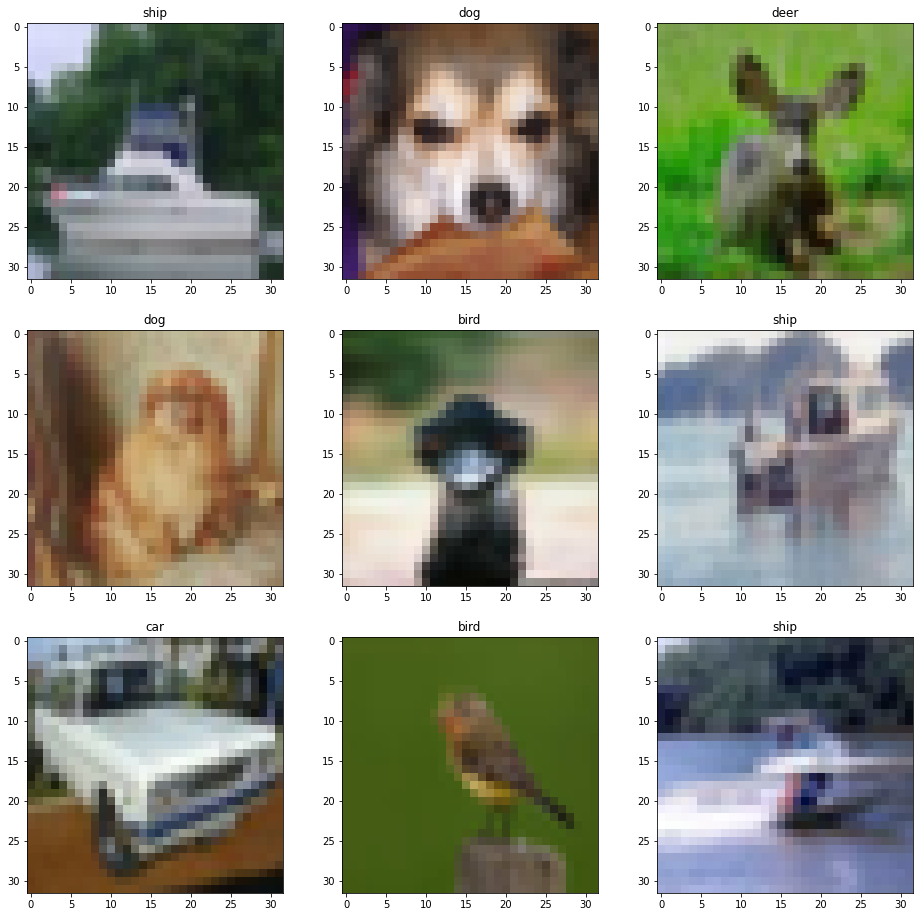

In [11]:
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Create the appropriate transform, load/download CIFAR10 train and test datasets with transform
# ----------- <Your code> ---------------
import torchvision
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                      torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR10('/data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10('/data', train=False, download=True, transform=transform)
# ----------- <End Your code> ---------------

# Define train_loader and test_loader
# ----------- <Your code> ---------------
#getter code
batch_size_train, batch_size_test = 9, 9

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False)
# ----------- <End Your code> ---------------

# Code to display images
batch_idx, (images, targets) = next(enumerate(train_loader))
fig, ax = plt.subplots(3,3,figsize = (16,16))
fig.set_size_inches(16,16)
for i in range(3):
  for j in range(3):
    image = images[i*3+j].permute(1,2,0)
    image = image/2 + 0.5
    ax[i,j].imshow(image)
    ax[i,j].set_title(f'{classes[targets[i*3+j]]}')
fig.show()

### Task 2: Create CNN and train it
Set up a convolutional neural network and have your data trained on it. You have to decide all the details in your network, overall your neural network should meet the following standards to receive full credit:

*   You should not use more than three convolutional layers and three fully connected layers
*   Accuracy on the test dataset should be **above** 50%



In [12]:
# ----------- <Your code> ---------------
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(3, 8, kernel_size=5)
    self.conv2 = nn.Conv2d(8, 16, kernel_size=5)
    self.conv3 = nn.Conv2d(16, 64, kernel_size=5)
    self.fc1 = nn.Linear(64 * 1 * 1, 128)
    # self.fc2 = nn.Linear(128, 64)
    # self.fc3 = nn.Linear(64, 10)
    self.pool = nn.MaxPool2d(2,2)

  def forward(self, x):
    # print(x.shape)

    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = F.relu(self.conv3(x))
    # print(x.shape); quit()
    x = x.view(-1, 64 * 1 * 1)
    x = F.relu(self.fc1(x))
    # x = F.relu(self.fc2(x))
    # x = F.relu(self.fc3(x))

    return F.log_softmax(x,-1)

cnn = CNN()
optimizer = optim.SGD(cnn.parameters(), lr=0.01, momentum=0.8)

test_losses = []
test_counter = []
max_epoch = 3

for epoch in range(1, max_epoch+1):
  train(cnn, epoch, optimizer)
  test(cnn, epoch, optimizer)

# ----------- <End Your code> ---------------

Test result on epoch 1: Avg loss is 1.403292426776886, Accuracy: 50.970001220703125%
Test result on epoch 2: Avg loss is 1.261019402282685, Accuracy: 54.90999984741211%
Test result on epoch 3: Avg loss is 1.2817385578539222, Accuracy: 55.119998931884766%


In [13]:
# This prints the accuracy of your model. 
print_accuracy(cnn, test_loader)

Accuracy of the network on the test images: 55 %


### Task 3: Plot misclassified test images
Plot some misclassified images in your test dataset:

*   select three images that are **misclassified** by your neural network
*   label each images with true label and predicted label
*   use `detach().cpu()` when plotting images if the image is in gpu

['car', 'car', 'plane', 'horse']


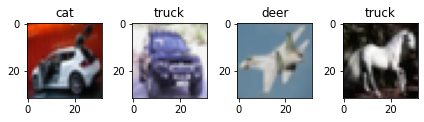

In [14]:
#print(test_dataset)
failed_images = []
failed_predicted = []
correct_labels = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn = cnn.to(device)

with torch.no_grad():
  for (images, labels) in test_loader:
    images, labels = images.to(device), labels.to(device)
    predictionLayer = cnn(images)
    hold, predicted_result = torch.max(predictionLayer.data, 1)

    for i in range(0,len(predicted_result)):
      if(predicted_result[i] != labels[i]):
        failed_images.append(images[i])
        failed_predicted.append(predicted_result[i])
        correct_labels.append(labels[i])

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4)

failed_images[0] = failed_images[0].detach().cpu() / 2 + 0.5
ax1.imshow(failed_images[0].permute(1,2,0))
ax1.set_title(classes[failed_predicted[0].item()])

failed_images[1] = failed_images[1].detach().cpu() / 2 + 0.5
ax2.imshow(failed_images[1].permute(1,2,0))
ax2.set_title(classes[failed_predicted[1].item()])

failed_images[2] = failed_images[2].detach().cpu() / 2 + 0.5
ax3.imshow(failed_images[2].permute(1,2,0))
ax3.set_title(classes[failed_predicted[2].item()])

failed_images[3] = failed_images[3].detach().cpu() / 2 + 0.5
ax4.imshow(failed_images[3].permute(1,2,0))
ax4.set_title(classes[failed_predicted[3].item()])


print([classes[correct_labels[i].item()] for i in range(4)])
fig.tight_layout()
fig.show()

# ----------- <Your code> ---------------


Questions (0 points): Are the mis-classified images also misleading to human eyes?

## Exercise 3: Transfer Learning (30 points)

In [15]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torch.optim as optim
import time

In practice, people won't train an entire CNN from scratch, because it is relatively rare to have a dataset of sufficient size (or sufficient computational power). Instead, it is common to pretrain a CNN on a very large dataset and then use the CNN either as an initialization or a fixed feature extractor for the task of interest.

In this task, you will learn how to use a pretrained CNN for CIFAR-10 classification.

### Task1: Load pretrained model

`torchvision.models` (https://pytorch.org/vision/stable/models.html) contains definitions of models for addressing different tasks, including: image classification, pixelwise semantic segmentation, object detection, instance segmentation, person keypoint detection and video classification.

First, you should load the **pretrained** ResNet-18 that has already been trained on [ImageNet](https://www.image-net.org/) using `torchvision.models`. If you are interested in more details about Resnet-18, read this paper https://arxiv.org/pdf/1512.03385.pdf.

In [16]:
resnet18 = models.resnet18(pretrained=True)
resnet18 = resnet18.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Task2: Create data loaders for CIFAR-10

Then you need to create a modified dataset and dataloader for CIFAR-10. Importantly, the model you load has been trained on **ImageNet** and it expects inputs as mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be **at least** 224. So you need to preprocess the CIFAR-10 data to make sure it has a height and width of 224. Thus, you should add a transform when loading the CIFAR10 dataset (see [`torchvision.transforms.Resize`](https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.Resize)).
This should be added appropriately to the `transform` you created in a previous task.

In [17]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                transforms.Resize((224,224))])

trainset = torchvision.datasets.CIFAR10(root='./data', train = True, download = True, transform = transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size = 9)

testset = torchvision.datasets.CIFAR10(root='./data', train = False, download = True, transform = transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size = 9)
# ----------- <Your code> ---------------

Files already downloaded and verified
Files already downloaded and verified


In [18]:
#epoch training
def train(classifier, epoch, optimizer, criterion=F.nll_loss):

  classifier.train() # we need to set the mode for our model

  for batch_idx, (images, targets) in enumerate(train_loader):
    images, targets = images.to(device), targets.to(device)
    optimizer.zero_grad()
    output = classifier(images)
    loss = criterion(output, targets) # Here is a typical loss function (negative log likelihood)
    loss.backward()
    optimizer.step()

def test(classifier, epoch, optimizer, criterion=F.nll_loss):

  classifier.eval() # we need to set the mode for our model

  test_loss = 0
  correct = 0

  with torch.no_grad():
    for images, targets in test_loader:
      images, targets = images.to(device), targets.to(device)
      output = classifier(images)
      test_loss += criterion(output, targets, reduction='sum').item()
      pred = output.data.max(1, keepdim=True)[1] # we get the estimate of our result by look at the largest class value
      correct += pred.eq(targets.data.view_as(pred)).sum() # sum up the corrected samples
  
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  test_counter.append(len(train_loader.dataset)*epoch)

  print(f'Test result on epoch {epoch}: Avg loss is {test_loss}, Accuracy: {100.*correct/len(test_loader.dataset)}%')

### Task3: Classify test data on pretrained model

Use the model you load to classify the **test** CIFAR-10 data and print out the test accuracy.

Don't be surprised if the accuracy is bad!

In [19]:
print(device)

cuda


In [20]:
test_losses = []
test_counter = []

optimizer = optim.SGD(resnet18.parameters(), lr=0.01, momentum=0.8)

epoch = 3
for i in range(1, epoch+1):
  train(resnet18, i, optimizer)
  test(resnet18, i, optimizer)
# ----------- <Your code> ---------------

Test result on epoch 1: Avg loss is nan, Accuracy: 10.0%
Test result on epoch 2: Avg loss is nan, Accuracy: 10.0%
Test result on epoch 3: Avg loss is nan, Accuracy: 10.0%


### Task 4: Fine-tune (i.e., update) the pretrained model for CIFAR-10

Now try to improve the test accuracy. We offer several possible solutions:

(1) You can try to directly continue to train the model you load with the CIFAR-10 training data. 

(2) For efficiency, you can try to freeze part of the parameters of the loaded models. For example, you can first freeze all parameters by

```
for param in model.parameters():
    param.requires_grad = False
```
and then unfreeze the last few layers by setting `somelayer.requires_grad=True`.

You are also welcome to try any other approach you can think of.


**Note:** You must print out the test accuracy and to get full credits, the test accuracy should be at least **80%**.

In [21]:
#resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [22]:
# ----------- <Your code> ---------------

crossEntropy = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.01, momentum=0.8)

test_losses = []
test_counter = []

epoch = 1
for i in range(1, epoch+1):
  train(resnet18, i, optimizer, criterion=crossEntropy)
  test(resnet18, i, optimizer)
# ----------- <End Your code> ---------------
  
print_accuracy(resnet18, test_loader)

Test result on epoch 1: Avg loss is nan, Accuracy: 10.0%
Accuracy of the network on the test images: 10 %


In [23]:
# ----------- <Your code> ---------------
resnet18 = models.resnet18(pretrained = True)
resnet18 = resnet18.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [24]:
# ----------- <Your code> ---------------
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                transforms.Resize((224,224))])

trainset = torchvision.datasets.CIFAR10(root='./data', train = True, download = True, transform = transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size = 9, shuffle = True, num_workers = 2)

testset = torchvision.datasets.CIFAR10(root='./data', train = False, download = True, transform = transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size = 9, shuffle = False, num_workers = 2)

Files already downloaded and verified
Files already downloaded and verified


In [25]:
def train(classifier, epoch, optimizer, criterion):
  classifier.train()

  for batch_idx, (images, targets) in enumerate(train_loader):
    images = images.to(device)
    targets = targets.to(device)
    optimizer.zero_grad()
    output = classifier(images)
    loss = criterion(output, targets)
    loss.backward()
    optimizer.step()

def test(classifier, epoch, optimizer):
  classifier.eval()
  test_loss = 0
  correct = 0

  with torch.no_grad():
    for images, targets in test_loader:
      images = images.to(device)
      targets = targets.to(device)
      output = classifier(images)
      test_loss += F.nll_loss(output, targets, reduction='sum').item()
      prediction = output.data.max(1, keepdim=True)[1]
      correct += prediction.eq(targets.data.view_as(prediction)).sum()
  
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  test_counter.append(len(train_loader.dataset)*epoch)

  print(f'Test result on epoch {epoch}: Avg loss is {test_loss}, Accuracy: {100.*correct/len(test_loader.dataset)}%')

In [26]:
# ----------- <Your code> ---------------
test_losses = []
test_counter = []

epoch = 3
for i in range(1, epoch+1):
  test(resnet18, i)

Test result on epoch 1: Avg loss is 0.7757911989659071, Accuracy: 0.029999999329447746%
Test result on epoch 2: Avg loss is 0.7757911989659071, Accuracy: 0.029999999329447746%
Test result on epoch 3: Avg loss is 0.7757911989659071, Accuracy: 0.029999999329447746%


In [28]:
crossEntropy = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.01, momentum=0.8)

test_losses = []
test_counter = []

epoch = 1
for i in range(1, epoch+1):
  train(resnet18, i, optimizer, crossEntropy)
  test(resnet18, i, optimizer)
# ----------- <Your code> ---------------

Test result on epoch 1: Avg loss is -18.987318799209596, Accuracy: 86.12999725341797%
